# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**[Response]** Based on the paper cited, data was sampled beginning in May 2008 through June 2013. The number of marketing campaigns is not specified but 42 unique "campaign" IDs of decreasing size were seen in the dataset. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
from sklearnex import patch_sklearn
# The names match scikit-learn estimators
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

from category_encoders.cat_boost import CatBoostEncoder

import scipy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import time
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [5]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
bank.value_counts('default')  

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

**[Response]** We notice that there are 3 "yes" values in the default column. This is not enough data to form conclusions so we set these 3 entries to "unknown" for purposes of this analysis. This is the only modification we make to our source data.

In [8]:
bank.value_counts('y')

y
no     36548
yes     4640
Name: count, dtype: int64

**[Response]** We notice that roughly 85% of the customers do not accept the offer. Without additional business context, this would still seem to be an impressive acceptance rate for a telemarketing campaign.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**[Response]** The business objective is to predict the success of a bank's telemarketing campaigns which sell interest rate products. We are provided several features related to customers as well as general economic indicators as inputs to our model. 

Using these features, we need to create a model that gives the business the highest confidence that customers with known characteristics can be identified (and likely targeted) for future marketing campaigns.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

**[Response]** In our initial data review, we noticed some outliers with the 'default' column where only 3 values were 'yes'. We move these to 'unknown' to ensure sufficient training data for the model

In [9]:
# replace 3 customers in default with 'unknown' 

bank.replace({'default': 'yes'}, 'unknown', inplace=True)

**[Response]** The duration column needs to be discarded for predictive modeling per the notes in the dataset.

In [10]:
bank.drop(columns=['duration'], inplace=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
# use the 'y' column as the target

X, y = bank.drop(columns=['y']), bank['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [12]:
# map the 'yes/no' values in the target column to numeric values for modeling purposes

target_map = {'yes': 1, 'no': 0}
y_train_numeric = y_train.map(target_map)
y_test_numeric = y_test.map(target_map)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

**[Response]** A baseline performance metric for our classifier would be to improve on the accuracy of guessing the largest class (Zero Rule). The Zero Rule is difficult to beat in this dataset as the baseline rejection rate for our test data is 88.3%. Thus, accuracy above 88.3% would be required to acheive better results than assuming all customers will reject the offer.

### Problem 8: Modeling

Build models for your data using several classifier types (Logistic Regression, Decision Tree, KNN, and SVM)

In [13]:
# explicit list of numeric/categorical features for different treatment in a pipeline

numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', \
                    'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_features = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', \
                        'poutcome', 'month', 'day_of_week' ]

In [14]:
# Package the hyperparameters into a list for batch testing

hyperparams = [ {}, {}, {}, {} ]

In [15]:
# Package classifiers into a list for batch testing

classifiers = [ LogisticRegression(random_state=42, max_iter=1000),
                KNeighborsClassifier(),
                DecisionTreeClassifier(random_state=42),
                SVC(random_state=42, cache_size=2000)
              ]

In [16]:
# fit a single classifier grid 

def fit_classifier_grid(classifier=None, X=None, y=None, **gs_params):
    """Fit a GridSearchCV object for the classifier provided
    
    Parameters
    ----------
    classifier: single classifier
    X: training vector
    y: target vector
    gs_params: additional parameters for GridSearchCV instantiation
    """
        
    categorical_transformer = Pipeline(
        [ 
            ('imputer_cat', SimpleImputer(strategy="constant", fill_value="unknown").set_output(transform="pandas")), 
            #('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
            ('catboost', CatBoostEncoder())
        ]
    )

    numeric_transformer = Pipeline(
        [
            ('imputer_num', SimpleImputer(strategy="mean").set_output(transform="pandas")),
            ('poly', PolynomialFeatures(degree=3))
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ('categorical', categorical_transformer, categorical_features),
            ('numeric', numeric_transformer, numeric_features)
        ]
    )

    cls_pipe = Pipeline( 
        [
            ('preprocess', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),
            ('classifier', classifier)
        ]
    )

    cls_grid = GridSearchCV(cls_pipe, **gs_params)
    cls_grid.fit(X, y)
    
    return cls_grid

In [17]:
# fit a list of classifiers

def fit_all_grids(cls_list=[], X=None, y=None, hp_list=[], **gs_params):
    """Fit GridSearchCV objects for a given list of classifiers 
    
    Parameters
    ----------
    cls_list: list of classifiers
    X: training vector
    y: target vector
    hp_list: list of hyperparameters for grid search
    gs_params: additional params for GridSearchCV instantiation
    """
    results = []
    for classifier, hyperparam in zip(cls_list, hp_list):
        classifier_name = type(classifier).__name__
        print('Running classifier: %s' % (classifier_name,))
        print()
    
        result = fit_classifier_grid(classifier, X, y, param_grid=hyperparam, **gs_params)
                         
        cputime = np.sum(result.cv_results_['mean_fit_time']) + \
                    np.sum(result.cv_results_['mean_score_time'])
    
        print('cputime: %.1f sec' % (cputime,))
        print('----------------------------------------------------')
    
        results.append(result)
        
    return results

In [18]:
# gather results for all classifiers with given hyperparameters (default settings in this run)

all_results = fit_all_grids(classifiers, X_train, y_train_numeric, hyperparams, \
                            n_jobs=5, cv=5, scoring='accuracy', verbose=10)

Running classifier: LogisticRegression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
cputime: 46.1 sec
----------------------------------------------------
Running classifier: KNeighborsClassifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
cputime: 5.0 sec
----------------------------------------------------
Running classifier: DecisionTreeClassifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
cputime: 8.3 sec
----------------------------------------------------
Running classifier: SVC

Fitting 5 folds for each of 1 candidates, totalling 5 fits
cputime: 19.2 sec
----------------------------------------------------


### Problem 9: Score the Model

What is the accuracy of your model?

In [19]:
# Report train/test scores on all classifier grids

def gen_scores(grid_list=[], X=None, y=None):
    """Generate scoring statistics from a list of fit grids
    
    Parameters
    ----------
    grid_list : list of GridSearchCV objects
    X: training vector
    y: target vector
    """
    scoring_metric = re.search('\((.+)_score', str(grid_list[0].scorer_)).group(1)
    scores_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train ' + scoring_metric, 'Test ' + scoring_metric])

    for grid in grid_list:
        best_est = grid.best_estimator_
        best_class = best_est['classifier']
        best_train_score = grid.best_score_
        best_test_score = grid.score(X, y)
        classifier_name = type(best_class).__name__
        cputime = np.sum(grid.cv_results_['mean_fit_time']) + \
                    np.sum(grid.cv_results_['mean_score_time'])
       
        print('Results for classifier: %s' % (classifier_name,))
        print()
        print(f'The best train score using scoring metric "{scoring_metric:s}" is: {best_train_score: .6f}')
        print(f'The best test  score using scoring metric "{scoring_metric:s}" is: {best_test_score: .6f}')
        #print(best_est.get_params())
        print('----------------------------------------------------')
    
        scores_df.loc[len(scores_df)] = [classifier_name, cputime, best_train_score, best_test_score]
    
    return scores_df

In [20]:
# score the fit classifiers

model_df = gen_scores(all_results, X_test, y_test_numeric)

Results for classifier: LogisticRegression

The best train score using scoring metric "accuracy" is:  0.899757
The best test  score using scoring metric "accuracy" is:  0.897669
----------------------------------------------------
Results for classifier: KNeighborsClassifier

The best train score using scoring metric "accuracy" is:  0.891320
The best test  score using scoring metric "accuracy" is:  0.889294
----------------------------------------------------
Results for classifier: DecisionTreeClassifier

The best train score using scoring metric "accuracy" is:  0.840091
The best test  score using scoring metric "accuracy" is:  0.840495
----------------------------------------------------
Results for classifier: SVC

The best train score using scoring metric "accuracy" is:  0.898483
The best test  score using scoring metric "accuracy" is:  0.893664
----------------------------------------------------


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [21]:
model_df

,Model,Train Time,Train accuracy,Test accuracy
0,LogisticRegression,46.140646,0.899757,0.897669
1,KNeighborsClassifier,5.034887,0.891320,0.889294
2,DecisionTreeClassifier,8.269060,0.840091,0.840495
3,SVC,19.238632,0.898483,0.893664


**[Response]** Using baseline parameters, most models had similar performance, except the decision tree classifier. Fit times varied widely, with Logistic Regression having a signficantly longer training time.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

**[Response]** In our initial exploration, we kept the default parameters for all 4 classifiers. In this section, we explore additional hyperparameters for each classifier. 

In [22]:
# Create unique hyperparameters for each classifer
lr_params  = { 'classifier__C': [1.0, 0.1, 0.01, 0.001], 
               'classifier__solver': ['lbfgs'] }
knn_params = { 'classifier__n_neighbors':list(range(1,50,2)) }
dt_params  = { 'classifier__max_depth': list(range(1,21,4)),
               'classifier__min_samples_split': list(range(2,21,4)),
               'classifier__criterion': ['gini', 'entropy', 'log_loss'],
               'classifier__min_samples_leaf': list(range(1,21,4)) }
svc_params = { 'classifier__gamma': [0.01, 0.02, 0.05, 0.1, 0.2, 1.0],
               'classifier__kernel': ['rbf', 'sigmoid'] }

# Package the hyperparameters into a list for batch testing
hyperparams = [ lr_params, knn_params, dt_params, svc_params ]

In [23]:
# gather results for all classifiers with given hyperparameters

all_results = fit_all_grids(classifiers, X_train, y_train_numeric, hyperparams, \
                            n_jobs=5, cv=5, scoring='accuracy', verbose=10)

Running classifier: LogisticRegression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
cputime: 123.2 sec
----------------------------------------------------
Running classifier: KNeighborsClassifier

Fitting 5 folds for each of 25 candidates, totalling 125 fits
cputime: 135.6 sec
----------------------------------------------------
Running classifier: DecisionTreeClassifier

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
cputime: 1484.7 sec
----------------------------------------------------
Running classifier: SVC

Fitting 5 folds for each of 12 candidates, totalling 60 fits
cputime: 349.1 sec
----------------------------------------------------


In [24]:
# score the fit classifiers

model_df = gen_scores(all_results, X_test, y_test_numeric)

Results for classifier: LogisticRegression

The best train score using scoring metric "accuracy" is:  0.900091
The best test  score using scoring metric "accuracy" is:  0.896091
----------------------------------------------------
Results for classifier: KNeighborsClassifier

The best train score using scoring metric "accuracy" is:  0.900577
The best test  score using scoring metric "accuracy" is:  0.897427
----------------------------------------------------
Results for classifier: DecisionTreeClassifier

The best train score using scoring metric "accuracy" is:  0.899697
The best test  score using scoring metric "accuracy" is:  0.897305
----------------------------------------------------
Results for classifier: SVC

The best train score using scoring metric "accuracy" is:  0.900243
The best test  score using scoring metric "accuracy" is:  0.897184
----------------------------------------------------


In [30]:
model_df

,Model,Train Time,Train roc_auc,Test roc_auc
0,LogisticRegression,139.933950,0.792407,0.803590
1,KNeighborsClassifier,166.425589,0.774906,0.795134
2,DecisionTreeClassifier,1739.312924,0.787451,0.796660
3,SVC,369.220548,0.716572,0.720708


**[Response]** Finally, we adjust our performance metric from "accuracy" to "roc_auc". We do this for two reasons: accuracy results can be less reliable when classes are imbalanced; additionally, using roc_auc allows comparison with other academic work on this dataset.

In [31]:
# now set the scoring from 'accuracy' to 'roc_auc'
# gather results for all classifiers with given hyperparameters

all_results = fit_all_grids(classifiers, X_train, y_train_numeric, hyperparams, \
                            n_jobs=5, cv=5, scoring='roc_auc', verbose=10)

Running classifier: LogisticRegression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
cputime: 112.5 sec
----------------------------------------------------
Running classifier: KNeighborsClassifier

Fitting 5 folds for each of 25 candidates, totalling 125 fits
cputime: 128.2 sec
----------------------------------------------------
Running classifier: DecisionTreeClassifier

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
cputime: 1461.6 sec
----------------------------------------------------
Running classifier: SVC

Fitting 5 folds for each of 12 candidates, totalling 60 fits
cputime: 318.7 sec
----------------------------------------------------


In [32]:
# score the fit classifiers

model_df = gen_scores(all_results, X_test, y_test_numeric)

Results for classifier: LogisticRegression

The best train score using scoring metric "roc_auc" is:  0.792407
The best test  score using scoring metric "roc_auc" is:  0.803590
----------------------------------------------------
Results for classifier: KNeighborsClassifier

The best train score using scoring metric "roc_auc" is:  0.774906
The best test  score using scoring metric "roc_auc" is:  0.795134
----------------------------------------------------
Results for classifier: DecisionTreeClassifier

The best train score using scoring metric "roc_auc" is:  0.787451
The best test  score using scoring metric "roc_auc" is:  0.796660
----------------------------------------------------
Results for classifier: SVC

The best train score using scoring metric "roc_auc" is:  0.716572
The best test  score using scoring metric "roc_auc" is:  0.720708
----------------------------------------------------


In [33]:
model_df

,Model,Train Time,Train roc_auc,Test roc_auc
0,LogisticRegression,112.548245,0.792407,0.803590
1,KNeighborsClassifier,128.177322,0.774906,0.795134
2,DecisionTreeClassifier,1461.629250,0.787451,0.796660
3,SVC,318.704282,0.716572,0.720708


**[Response]** Here we note that the SVC classifier performed poorly in our analysis, whereas it performed better in our comparison analysis. We expect that a fuller exploration of hyperparameters, including the slower-running linear and polynomial kernels could contribute meaningful performance gains to our SVC model. 

Text(0.5, 1.0, 'Confusion Matrix - Best Classifier')

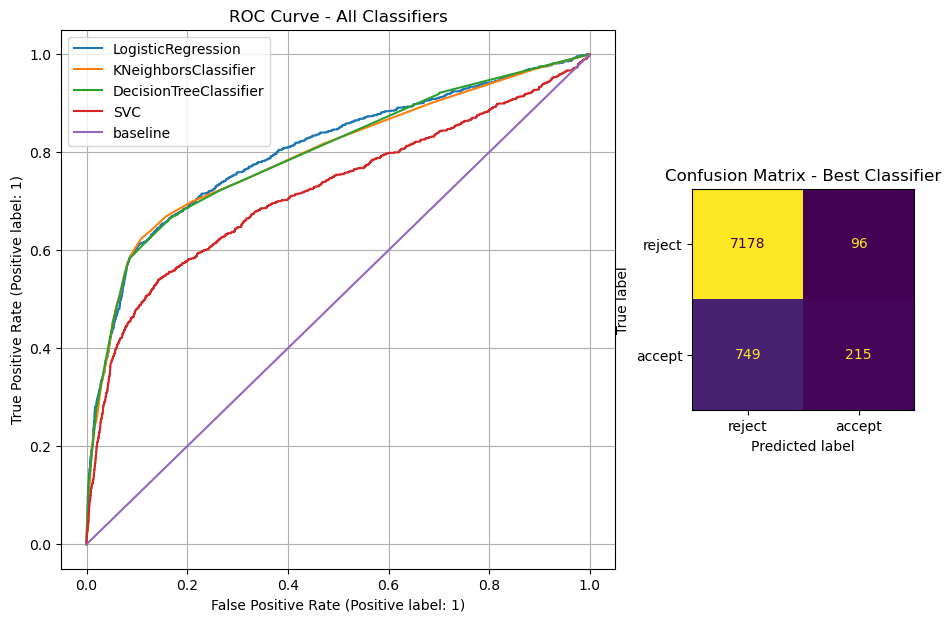

In [34]:
# Plot ROC Curve for all classifiers 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,7), gridspec_kw={'width_ratios': [2.5, 1]})
for grid in all_results:
    classifier_name = type(grid.best_estimator_['classifier']).__name__
    RocCurveDisplay.from_estimator(grid, X_test, y_test_numeric, pos_label=1, ax=axes[0], label=classifier_name)
axes[0].grid()
axes[0].plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label='baseline')
axes[0].set_title('ROC Curve - All Classifiers')
axes[0].legend()

# Plot confusion matrix from the best classifier only

ConfusionMatrixDisplay.from_predictions(y_test_numeric, all_results[0].predict(X_test), ax=axes[1], \
                                        colorbar=False, display_labels=['reject', 'accept'])
axes[1].set_title('Confusion Matrix - Best Classifier')

**[Response]** We include below the results from a prior academic work for comparison. The full results of this study can be [found here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

We used many classifiers in common: DT, SV, LR. Our analysis included KNN, whereas the other study included a neural net. The neural net was able to obtain the best results in our comparison study.

Overall our results compare favorably with this study.

![Comparison Study Results](img/bank-results.png)

#### Additional Scoring Metrics

**[Response]**
We discuss 2 additional scoring metrics beyond accuracy and roc_auc. Using our confusion matrix above, we calculate both the MCC and lift metrics as described [here](https://biodatamining.biomedcentral.com/articles/10.1186/s13040-023-00322-4) and [here](https://rasbt.github.io/mlxtend/user_guide/evaluate/lift_score/). Both metrics use the confusion matrix to assess the quality of a prediction.

MCC, the Matthews correlation coefficient, provides additional context for predictive classification. The MCC ranges from -1 to +1. -1 corresponds to perfect inverse predictive ability, and +1 corresponds with perfect preditive ability. Derivation of the MCC metric is shown below:



![MCC](img/MCC.png)

Similarly, the Lift metric provides support for the quality of a prediction vs. that of random predictions. Lift scores range from 0 to ∞. Any score above the target rate is suggestive of predictive ability. The Lift metric calculation is shown below:

![Lift](img/Lift.png)

Using the confusion matrix for our best classifier (Logistic Regression), we calculate the MCC score at 0.35, and the Lift score of 5.91. This compares with 0.02 and 5.39 for the Zero Rule (baseline). Both statistics, and especially the MCC, are suggestive of the positive impact of our model on the likelihood our model predicts consumers' acceptance of the bank's interest rate product.

### Conclusions
**[Response]**
Using 4 classifiers (Logistic Regression, KNN, Decision Trees, and SVM), we applied standard modeling techniques to optimize predictions about customer behavior. Our models predict which customers are likely to purchase the bank's interest rate product based on customer information readily available to the business.

All classifiers had similar performance (excepting the SVC), despite having very different runtimes and underlying methods.

Our first attempts at optimizing accuracy showed that our models were only slightly better than the Zero Rule, where the Zero Rule accuracy was 88.3% and our models achieved 89.7%.

We optimized our models against the roc_auc metric for comparison with a similar study on this dataset, and found we were reasonably close to this study's performance across most models. Our SVC model would need additional tuning to match the results found in this study.

Finally, we discussed 2 other metrics (MCC and Lift) as a way of expressing predictive ability. Using the MCC especially, we noted a moderate predictive ability of our models.

We believe additional performance gains can be made by taking 2 additional actions:
1. continued tuning of hyperparameters (with extra focus on SVC)
2. selection of training data to focus more on the rarer data - customers that accepted the offer

### Next Steps
**[Response]**
As a business conclusion, our models are aligned with those of other researchers using the same dataset. These models give some predictive ability but the best available techniques have room to improve when it comes to predicting accurately which customers will buy the product.

We already see the ability of our models to make good predictive suggestions using higher sensitivity, so one application of our data would be to provide the business subsets of customers which have a higher likelihood of accepting the offer than others. Following additional model tuning (noted in our conclusion), we expect our predictions to be improved further.

Additionally, we would recommend the business consider adding additional metrics if possible that may improve accuracy. Another suggestion would be to consider lower cost ways of contacting and/or marketing to consumers which might provide a greater reach than targeted marketing alone. 

##### Questions